In [48]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pywt
import os

%matplotlib inline

Размер матрицы: (976, 736)
Тип данных: float64
Диапазон значений: [0.0, 254.0]


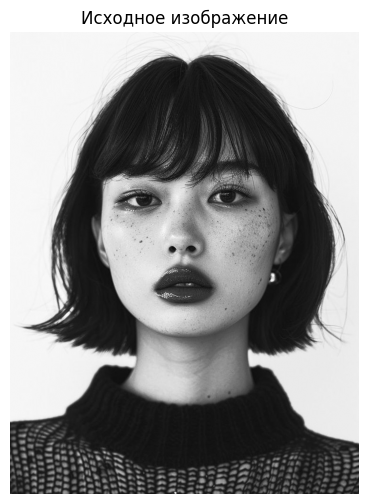

In [49]:
image = Image.open('portret.jpg').convert('L')
image_array = np.array(image, dtype=float)

print(f"Размер матрицы: {image_array.shape}")
print(f"Тип данных: {image_array.dtype}")
print(f"Диапазон значений: [{image_array.min()}, {image_array.max()}]")

# Показываем исходное изображение
plt.figure(figsize=(8, 6))
plt.imshow(image_array, cmap='gray')
plt.title('Исходное изображение')
plt.axis('off')
plt.show()

Используемый вейвлет: db4
Уровень разложения: 4



Всего вейвлет-коэффициентов: 763524


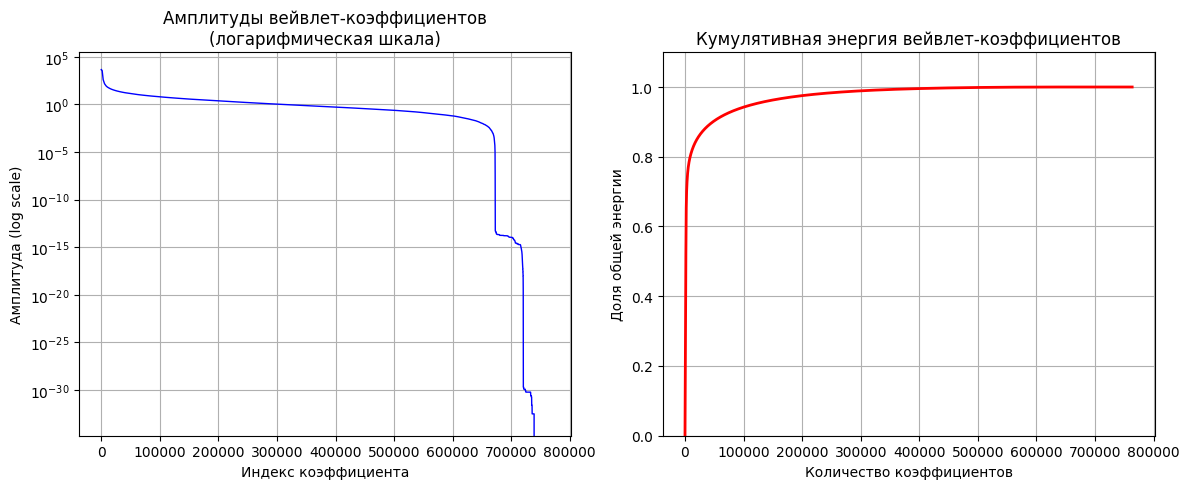

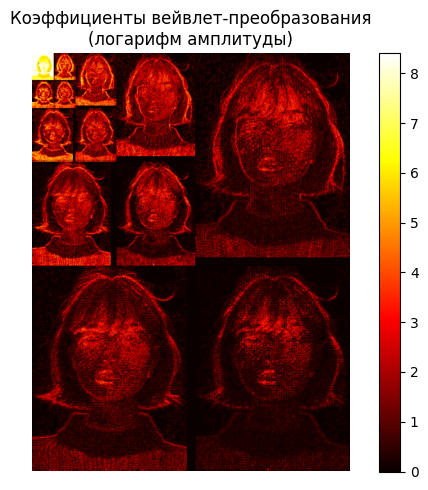

In [50]:
# === ВЕЙВЛЕТ-ПРЕОБРАЗОВАНИЕ И АНАЛИЗ ===
wavelet_name = 'db4'
level = 4

print(f"Используемый вейвлет: {wavelet_name}")
print(f"Уровень разложения: {level}")

# Выполняем многоуровневое вейвлет-разложение
coeffs = pywt.wavedec2(image_array, wavelet=wavelet_name, level=level)
coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)

magnitudes = np.abs(coeff_arr)
magnitudes_flat = magnitudes.ravel()
magnitudes_sorted = np.sort(magnitudes_flat)[::-1]# Сортируем по убыванию

total_coeffs = len(magnitudes_sorted)
print(f"\nВсего вейвлет-коэффициентов: {total_coeffs}")

# Вычисляем кумулятивную энергию
cumulative_energy = np.cumsum(magnitudes_sorted) / np.sum(magnitudes_sorted)

# График амплитуд коэффициентов и кумулятивной энергии
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.semilogy(magnitudes_sorted, 'b-', linewidth=1)
plt.title('Амплитуды вейвлет-коэффициентов\n(логарифмическая шкала)')
plt.xlabel('Индекс коэффициента')
plt.ylabel('Амплитуда (log scale)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(cumulative_energy, 'r-', linewidth=2)
plt.title('Кумулятивная энергия вейвлет-коэффициентов')
plt.xlabel('Количество коэффициентов')
plt.ylabel('Доля общей энергии')
plt.grid(True)
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()

# Визуализация коэффициентов вейвлета
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
coeff_vis = np.log(1 + np.abs(coeff_arr))
plt.imshow(coeff_vis, cmap='hot')
plt.title('Коэффициенты вейвлет-преобразования\n(логарифм амплитуды)')
plt.axis('off')
plt.colorbar()

plt.tight_layout()
plt.show()

In [51]:
# === ФУНКЦИИ ДЛЯ ВЕЙВЛЕТ-СЖАТИЯ ===

def compress_wavelet(coeff_arr, keep_ratio):
    """
    Сжатие вейвлет-коэффициентов - сохранение только максимальных по амплитуде
    """
    magnitudes = np.abs(coeff_arr)
    
    total_coeffs = coeff_arr.size
    keep_count = int(total_coeffs * keep_ratio)
    
    # Находим пороговое значение
    if keep_count > 0:
        threshold = np.partition(magnitudes.ravel(), -keep_count)[-keep_count]
    else:
        threshold = np.max(magnitudes) + 1
    
    mask = magnitudes >= threshold
    
    compressed_coeffs = coeff_arr * mask
    
    return compressed_coeffs, mask, keep_count

def reconstruct_from_wavelet(compressed_coeffs, coeff_slices, wavelet_name, original_shape):
    """Восстановление изображения из сжатых вейвлет-коэффициентов"""
    coeffs_fill = pywt.array_to_coeffs(compressed_coeffs, coeff_slices, output_format='wavedec2')
    reconstructed = pywt.waverec2(coeffs_fill, wavelet=wavelet_name)
    reconstructed = reconstructed[:original_shape[0], :original_shape[1]]
    reconstructed = np.clip(reconstructed, 0, 255)
    
    return reconstructed.astype(np.uint8)


РЕЗУЛЬТАТЫ СЖАТИЯ С ПОМОЩЬЮ ВЕЙВЛЕТ-ПРЕОБРАЗОВАНИЯ
Уровень    Коэфф.   % энергии    Ошибка Фробениуса   
------------------------------------------------------------
10%        76352    92.74     % 1817.54             
5%         38176    88.71     % 2996.07             
1%         7635     79.12     % 7438.86             
0.5%       3817     73.74     % 12435.63            


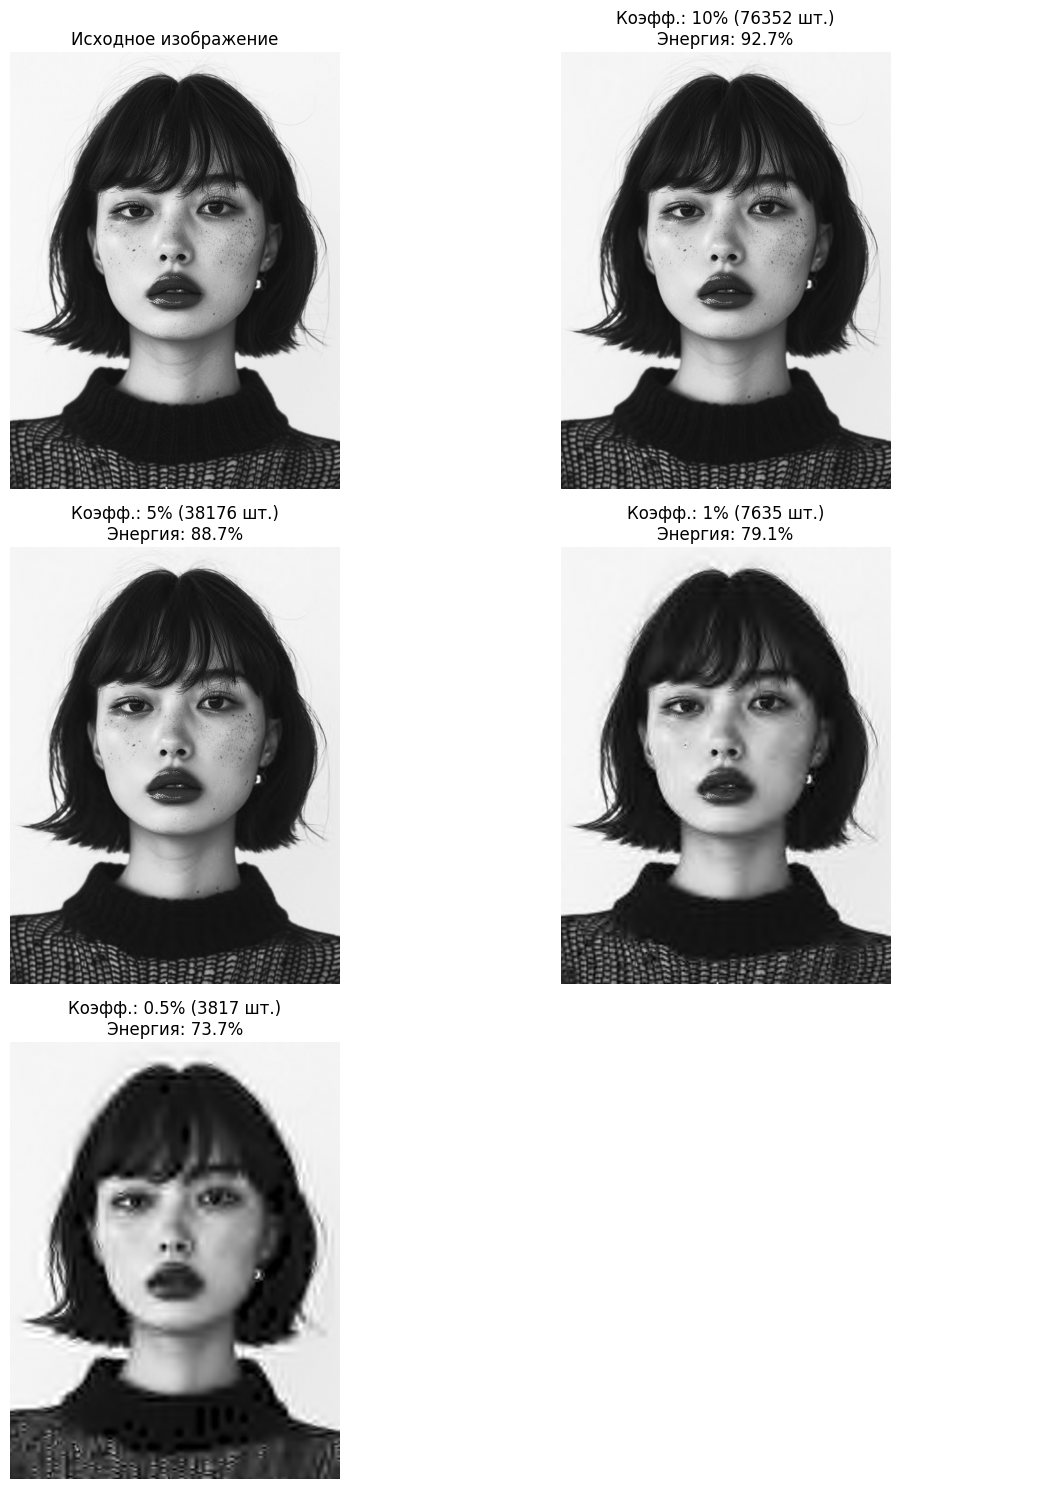

In [52]:
# === ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ СЖАТИЯ ===

compression_ratios = [0.10, 0.05, 0.01, 0.005]
ratios_names = ['10%', '5%', '1%', '0.5%']

print("\n" + "="*80)
print("РЕЗУЛЬТАТЫ СЖАТИЯ С ПОМОЩЬЮ ВЕЙВЛЕТ-ПРЕОБРАЗОВАНИЯ")
print("="*80)
print(f"{'Уровень':<10} {'Коэфф.':<8} {'% энергии':<12} {'Ошибка Фробениуса':<20}")
print("-" * 60)

fig, axes = plt.subplots(3, 2, figsize=(12, 15))
axes = axes.ravel() 

axes[0].imshow(image_array, cmap='gray')
axes[0].set_title('Исходное изображение')
axes[0].axis('off')

# Восстановленные изображения для разных уровней сжатия
for i, (ratio, name) in enumerate(zip(compression_ratios, ratios_names)):
    # Сжимаем вейвлет-коэффициенты
    compressed_coeffs, mask, kept_coeffs = compress_wavelet(coeff_arr, ratio)
    
    reconstructed = reconstruct_from_wavelet(compressed_coeffs, coeff_slices, wavelet_name, image_array.shape)
    
    total_energy = np.sum(magnitudes_sorted)
    kept_energy = np.sum((np.abs(compressed_coeffs)))
    energy_percentage = (kept_energy / total_energy) * 100
    
    error_norm = np.linalg.norm(image_array - reconstructed, 'fro')
    
    print(f"{name:<10} {kept_coeffs:<8} {energy_percentage:<10.2f}% {error_norm:<20.2f}")
    
    axes[i+1].imshow(reconstructed, cmap='gray')
    axes[i+1].set_title(f'Коэфф.: {name} ({kept_coeffs} шт.)\nЭнергия: {energy_percentage:.1f}%')
    axes[i+1].axis('off')

total_plots_used = len(compression_ratios) + 1
for j in range(total_plots_used, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [53]:
# === АНАЛИЗ ЭФФЕКТИВНОСТИ СЖАТИЯ ===

print("\n" + "="*80)
print("ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ")
print("="*80)
print(f"Размер исходной матрицы: {image_array.shape}")
print(f"Общее количество элементов: {image_array.size}")
print(f"Размер массива коэффициентов: {coeff_arr.shape}")

# Экономия памяти для разных уровней сжатия
print("\nЭКОНОМИЯ ПАМЯТИ:")
print(f"{'Уровень':<10} {'Коэфф.':<8} {'Исходный размер':<18} {'Сжатый размер':<16} {'Коэф. сжатия':<12}")
print("-" * 70)

m, n = image_array.shape
for ratio, name in zip(compression_ratios, ratios_names):
    kept_coeffs = int(coeff_arr.size * ratio)
    original_size = m * n
    compressed_size = kept_coeffs * 2  # значения (вещественные)
    
    compression_ratio = original_size / compressed_size if compressed_size > 0 else float('inf')
    
    print(f"{name:<10} {kept_coeffs:<8} {original_size:<18} {compressed_size:<16} {compression_ratio:<10.2f}x")



ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ
Размер исходной матрицы: (976, 736)
Общее количество элементов: 718336
Размер массива коэффициентов: (1002, 762)

ЭКОНОМИЯ ПАМЯТИ:
Уровень    Коэфф.   Исходный размер    Сжатый размер    Коэф. сжатия
----------------------------------------------------------------------
10%        76352    718336             152704           4.70      x
5%         38176    718336             76352            9.41      x
1%         7635     718336             15270            47.04     x
0.5%       3817     718336             7634             94.10     x
